# Portfolio Optimization

### Part 1: Collect and Analyze Data

1. Obtain risk-free rates from Ken French's data library using `pandas_datareader` and use these data to calculate log excess returns for each industry-month. As a reminder, log excess returns are defined as log returns minus log risk-free rate.
2. Calculate and display average returns and their volatilities in the 1980-2021 sample.
3. Calculate the covariance matrix

### Part 2: Find Optimal Portfolio

Let $\mathbf{\mu}$ represent a vector of expected excess returns and $\Sigma$ represent the covariance matrix. Then a portfolio with weights $\mathbf{w}$ has a Sharpe ratio of:
$$ SR(\mathbf{w}) = \frac{\mathbf{w}' \times \mathbf{\mu}}{ \sqrt{\mathbf{w}'\times \Sigma \times \mathbf{w}} }$$
where $'$ denotes a transpose (`.transpose()` in numpy) and $\times$ denotes matrix multiplication (`@` in numpy).

The optimal long-only portfolio is one that maximizes the Sharpe Ratio subject to all weights being between 0 and 1 and all weights summing to 1. In other words, the optimal portfolio $\mathbf{w}^\ast$ is given by:
$$ \mathbf{w}^\ast = \arg \max*{\mathbf{w}} SR(\mathbf{w}) \text{ such that } \mathbf{0}\_N \leq \mathbf{w} \leq \mathbf{1}\_N \text{ and } \mathbf{1}\_N' \times \mathbf{w} = 1 $$
where $\mathbf{0}_N$ is an $N$-element vector of zeros, $\mathbf{1}_N$ is an $N$-element vector of ones, and transpose and matrix multiplication are as previously defined. Note that $\mathbf{1}_N' \times \mathbf{w} = 1$ constraint is equivalent to $\sum*{i=1}^N w_i = 1$. I wrote it in matrix form to make the next part easier.

1. Use `scipy`'s `minimize()` function to find the optimal portfolio assuming future expected returns and covariances will be the same as in the past.
2. Which industries does the optimal portfolio take a non-zero position in? Report the weights for these industries only.
3. Report the Sharpe Ratio of the optimal portfolio i.e. the maximum Sharpe Ratio you can achieve "in-sample" (i.e. using past data).

Hint: use the `bounds` argument of `minimize()` to make sure your weights are between 0 and 1. Use the `constraints` argument to set a `LinearConstraint` that ensures that $\mathbf{1}_N' \times \mathbf{w} = 1$. To use these arguments, import `Bounds` and `LinearConstraint` from `scipy.optimize`.

- Set `Bounds`'s `lb` and `ub` arguments to set lower and upper bounds respectively.
- To configure `LinearConstraint`'s `A`, `lb` and `ub`, think about it as defining the following inequalities $lb \leq A' \times \mathbf{w} \leq ub$. Compare to your desired constraint $\mathbf{1}_N' \times \mathbf{w} = 1$.

### Part 3 (Optional; Bonus): Infer the Market's Expected Returns

If all investors use mean-variance analysis with the best available information to allocate their portfolio, then they all should choose the same portfolio i.e. invest the same fractions of the risky part of their portfolio in a given industry. In equilibrium, this demand of investors for assets must equal their supply. This means that the market cap shares of each industry that we observe in the data (market cap share = market cap of an industry / total market cap of all industries) are in fact the portfolio weights chosen by optimizing investors.

To see why this is the case, imagine there were only two industries A and B. Every investor uses the same information as every other investor to calculate their optimal portfolio and decides to allocate 35% into A and 65% into B. This means that 35% of all the invested money in the world should be in A and 65% should be in B. In other words, the market cap of A divided by the total market cap of A and B should be 35%.

We can use this result to determine the returns on each industry expected by investors. In other words, we can work backwards. Rather than making our own assumptions about expected returns and computing optimal weights given that assumption, we take the weights in the data and figure out what investors must expect future returns to be to have chosen these weights. Inverting mean-variance analysis to calculate expected returns from weights rather than weights from expected returns was the idea of [Fischer Black and Robert Litterman](https://en.wikipedia.org/wiki/Black%E2%80%93Litterman_model).

Given covariance matrix $\Sigma$, the optimal portfolio weights (allowing for short positions) as a function of expected excess returns $\mathbf{\mu}$ are given by the simple formula:
$$ \mathbf{w}\_t(\mathbf{\mu}) = \frac{\Sigma^{-1}\mathbf{\mu}}{ \mathbf{1}\_N' \Sigma^{-1} \mathbf{\mu} } $$
where $^{-1}$ refers to the matrix inverse, which can be calculated using the `numpy.linalg.inv()` function.

_Note: the reason you could not use this formula in Part 2 is that it allows for short positions (i.e. negative weights), whereas in Part 2 I asked you to form a long-only portfolio._

1. Compute industry market cap shares in the data in the last month of the sample. Denote them as $\mathbf{w}_d$.
2. Use `scipy.optimize`'s `fsolve()` function to solve for the value of $\mathbf{\mu}$ that solves $ \mathbf{w}\_t(\mathbf{\mu}) = \mathbf{w}\_d$.
3. Store historical average returns and the Black-Litterman expected returns in the same `DataFrame`. Compare the results. Which industries do investors expect to perform better than in the past? What about worse?


### Part 1


In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

1.


In [8]:
# read csv data
df_csv = pd.read_csv("industry_returns.csv")
df_csv = df_csv.set_index("Date")
df_csv.index = pd.to_datetime(df_csv.index).to_period('M')
df_csv.head()

,industry,vwret,ewret,nfirms,avgsize
Date,,,,,
1926-07,NoDur,1.45,1.16,90,31.58
1926-08,NoDur,3.97,5.00,90,32.00
1926-09,NoDur,1.14,0.03,90,33.18
1926-10,NoDur,-1.24,-2.55,90,33.32
1926-11,NoDur,5.20,6.00,90,32.83


In [ ]:
# read Ken French's data library
data = web.DataReader('F-F_Research_Data_Factors',
                         'famafrench',
                         start='1980-01',
                         end='2021-12')
df_lib = data[0]
df_lib.index = df_lib.index.to_timestamp().to_period('M')
df_lib.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1980-01,5.51,1.62,1.75,0.80
1980-02,-1.22,-1.85,0.61,0.89
1980-03,-12.90,-6.64,-1.01,1.21
1980-04,3.97,1.05,1.06,1.26
1980-05,5.26,2.13,0.38,0.81


In [10]:
# merge two datasets
df = df_csv.merge(df_lib, how='inner', left_index=True, right_index=True)
display(df)

,industry,vwret,ewret,nfirms,avgsize,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,
1980-01,NoDur,3.12,7.84,385,177.72,5.51,1.62,1.75,0.80
1980-01,Durbl,9.06,11.69,150,321.83,5.51,1.62,1.75,0.80
1980-01,Manuf,7.06,11.90,816,242.32,5.51,1.62,1.75,0.80
1980-01,Enrgy,14.15,19.13,191,953.31,5.51,1.62,1.75,0.80
1980-01,HiTec,7.37,14.81,382,246.88,5.51,1.62,1.75,0.80
...,...,...,...,...,...,...,...,...,...
2021-12,Telcm,3.90,-0.30,52,25946.89,3.10,-1.66,3.28,0.01
2021-12,Shops,1.29,1.97,279,18911.07,3.10,-1.66,3.28,0.01
2021-12,Hlth,6.72,-5.53,810,5055.56,3.10,-1.66,3.28,0.01


In [11]:
# calculate the excess returns
df["excess_ew"] = np.log(1 + df["ewret"] / 100) - np.log(1 + df["RF"] / 100)
df["excess_vw"] = np.log(1 + df["vwret"] / 100) - np.log(1 + df["RF"] / 100)
display(df["excess_ew"])
display(df["excess_vw"])

Date
1980-01    0.067510
1980-01    0.102589
1980-01    0.104467
1980-01    0.167077
1980-01    0.130140
             ...   
2021-12   -0.003105
2021-12    0.019408
2021-12   -0.056988
2021-12    0.081111
2021-12    0.018035
Freq: M, Name: excess_ew, Length: 5040, dtype: float64

Date
1980-01    0.022755
1980-01    0.078760
1980-01    0.060251
1980-01    0.124375
1980-01    0.063142
             ...   
2021-12    0.038159
2021-12    0.012718
2021-12    0.064938
2021-12    0.082125
2021-12    0.048309
Freq: M, Name: excess_vw, Length: 5040, dtype: float64

2.


In [12]:
ewret_average = df.groupby('industry')['excess_ew'].mean()
ewret_volatilities = df.groupby('industry')['excess_ew'].std()

# The average returns and volatilities for ewret
display(ewret_average)
display(ewret_volatilities)

industry
Durbl    0.005084
Enrgy   -0.000069
HiTec    0.007670
Hlth     0.008384
Manuf    0.006659
NoDur    0.006490
Other    0.006921
Shops    0.006153
Telcm    0.006019
Utils    0.007669
Name: excess_ew, dtype: float64

industry
Durbl    0.070704
Enrgy    0.096446
HiTec    0.080354
Hlth     0.075048
Manuf    0.060670
NoDur    0.050720
Other    0.051079
Shops    0.061892
Telcm    0.075684
Utils    0.034445
Name: excess_ew, dtype: float64

In [13]:
vwret_average = df.groupby('industry')['excess_vw'].mean()
vwret_volatilities = df.groupby('industry')['excess_vw'].std()

# The average returns and volatilities for vwret
display(vwret_average)
display(vwret_volatilities)

industry
Durbl    0.006320
Enrgy    0.004458
HiTec    0.006546
Hlth     0.007483
Manuf    0.006600
NoDur    0.007737
Other    0.005813
Shops    0.007873
Telcm    0.005424
Utils    0.005745
Name: excess_vw, dtype: float64

industry
Durbl    0.072099
Enrgy    0.063672
HiTec    0.067041
Hlth     0.045792
Manuf    0.050444
NoDur    0.041118
Other    0.052876
Shops    0.049812
Telcm    0.049336
Utils    0.039296
Name: excess_vw, dtype: float64

3.


In [14]:
# the covariance matrix for ewret
df_cov_ewret = df.pivot(columns='industry', values='excess_ew')
cov_matrix_ewret = df_cov_ewret.cov()
print(cov_matrix_ewret)

industry     Durbl     Enrgy     HiTec     Hlth      Manuf     NoDur  \
industry                                                               
Durbl     0.004999  0.004361  0.004650  0.004189  0.004036  0.003274   
Enrgy     0.004361  0.009302  0.004137  0.003933  0.004187  0.002966   
HiTec     0.004650  0.004137  0.006457  0.005312  0.004122  0.003296   
Hlth      0.004189  0.003933  0.005312  0.005632  0.003672  0.003005   
Manuf     0.004036  0.004187  0.004122  0.003672  0.003681  0.002859   
NoDur     0.003274  0.002966  0.003296  0.003005  0.002859  0.002572   
Other     0.003282  0.003222  0.003286  0.003030  0.002888  0.002385   
Shops     0.004074  0.003623  0.004162  0.003733  0.003475  0.002973   
Telcm     0.004234  0.003828  0.005385  0.004437  0.003706  0.003057   
Utils     0.001148  0.001545  0.000976  0.000998  0.001109  0.000921   

industry     Other     Shops     Telcm     Utils  
industry                                          
Durbl     0.003282  0.004074  0.0

In [15]:
# the covariance matrix for vwret
df_cov_vwret = df.pivot(columns='industry', values='excess_vw')
cov_matrix_vwret = df_cov_vwret.cov()
print(cov_matrix_vwret)

industry     Durbl     Enrgy     HiTec     Hlth      Manuf     NoDur  \
industry                                                               
Durbl     0.005198  0.002244  0.003208  0.001711  0.002925  0.001753   
Enrgy     0.002244  0.004054  0.001789  0.001152  0.002031  0.001225   
HiTec     0.003208  0.001789  0.004494  0.001759  0.002519  0.001448   
Hlth      0.001711  0.001152  0.001759  0.002097  0.001569  0.001387   
Manuf     0.002925  0.002031  0.002519  0.001569  0.002545  0.001605   
NoDur     0.001753  0.001225  0.001448  0.001387  0.001605  0.001691   
Other     0.002971  0.001971  0.002451  0.001678  0.002374  0.001684   
Shops     0.002597  0.001337  0.002381  0.001550  0.002051  0.001598   
Telcm     0.002077  0.001348  0.002121  0.001315  0.001651  0.001293   
Utils     0.001011  0.001225  0.000672  0.000807  0.000961  0.000927   

industry     Other     Shops     Telcm     Utils  
industry                                          
Durbl     0.002971  0.002597  0.0

### Part 2


In [16]:
from scipy.optimize import minimize, Bounds, LinearConstraint
import math
import matplotlib.pyplot as plt

1.


In [17]:
# find the optimal portfolio
def func(W, expected_returns, cov):
    SR = W.T @ expected_returns / math.sqrt(W.T @ cov @ W)
    return -SR


def optimize(expected_returns, cov, size):
    W = np.ones((size, 1)) * (1.0 / size)
    bounds = Bounds(0, 1)
    A = np.ones((size, 1))
    linear_constraints = LinearConstraint(A.T, 1, 1)

    opt_weights = minimize(func,
                           x0=W,
                           args=(expected_returns, cov),
                           method='SLSQP',
                           bounds=bounds,
                           constraints=linear_constraints)

    return opt_weights['x']

In [21]:
cov_matrix_ew_excess = df.pivot(columns='industry', values='excess_ew').cov()
cov_matrix_ew_excess = cov_matrix_ew_excess.to_numpy()
cov_matrix_vw_excess = df.pivot(columns='industry', values='excess_vw').cov()
cov_matrix_vw_excess = cov_matrix_vw_excess.to_numpy()

ew_average = df.groupby('industry')["excess_ew"].mean()
vw_average = df.groupby('industry')["excess_vw"].mean()

ew_average = np.array(ew_average).reshape(10, 1)
vw_average = np.array(vw_average).reshape(10, 1)

opt_weights_ew = optimize(ew_average, cov_matrix_ew_excess, 10)
opt_weights_vw = optimize(vw_average, cov_matrix_vw_excess, 10)

print(opt_weights_ew)
print(opt_weights_vw)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.26069156e-02
 0.00000000e+00 8.10257159e-16 1.54644549e-15 0.00000000e+00
 0.00000000e+00 9.37393084e-01]
[0.00000000e+00 4.15401222e-17 2.25251719e-17 1.75805307e-01
 0.00000000e+00 4.53890625e-01 6.77363160e-18 9.98610340e-02
 0.00000000e+00 2.70443033e-01]


C:\Users\58336\AppData\Local\Temp\ipykernel_9620\3113632264.py:13: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt_weights = minimize(func,
C:\Users\58336\AppData\Local\Temp\ipykernel_9620\3113632264.py:13: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  opt_weights = minimize(func,


<BarContainer object of 10 artists>

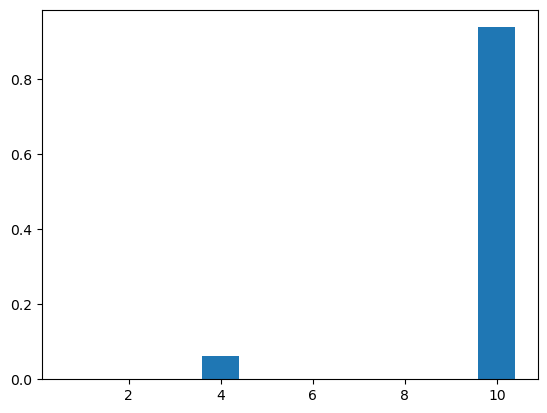

In [22]:
plt.bar(range(1, 11), opt_weights_ew)

<BarContainer object of 10 artists>

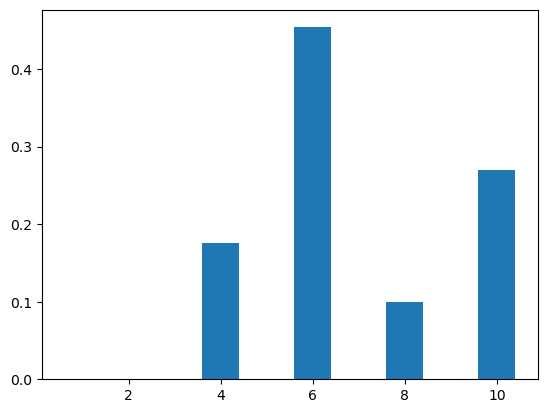

In [23]:
plt.bar(range(1, 11), opt_weights_vw)

2.


In [24]:
# report non-zero portfolio industry
def report_industry(industry, weights):
    res = []
    for i in range(10):
        if (weights[i] > 0):
            res.append(industry[i])

    print(res)


industry = [
    'Durbl', 'Enrgy', 'HiTec', 'Hlth', 'Manuf', 'NoDur', 'Other', 'Shops',
    'Telcm', 'Utils'
]
report_industry(industry, opt_weights_ew)
report_industry(industry, opt_weights_vw)

['Hlth', 'NoDur', 'Other', 'Utils']
['Enrgy', 'HiTec', 'Hlth', 'NoDur', 'Other', 'Shops', 'Utils']


3.


In [25]:
# maximum Sharpe Ratio
max_SR_ew = -func(opt_weights_ew, ew_average, cov_matrix_ew_excess)
print(max_SR_ew)

max_SR_vw = -func(opt_weights_vw, ew_average, cov_matrix_vw_excess)
print(max_SR_vw)

[0.22440455]
[0.19590949]


### Part 3


In [26]:
import scipy.optimize

1.


In [27]:
#calculate industry market cap share
df_last_month = df[df.index == '2021-12']
nfirms = df_last_month["nfirms"].to_numpy()
avgsize = df_last_month["avgsize"].to_numpy()

w_d = nfirms * avgsize
w_d = w_d / sum(w_d)
print(w_d)

[0.03440041 0.03196023 0.07741833 0.02162361 0.36587637 0.02795258
 0.10930839 0.08483742 0.02452183 0.22210084]


2.


In [28]:
def func_2(x, w_d, cov):
    A = np.ones((10, 1))
    w_t = (np.linalg.inv(cov) @ x) / (A.T @ np.linalg.inv(cov) @ x)
    return w_t - w_d


def solve_expected_returns(x0, cov, w_d):
    x = scipy.optimize.fsolve(func_2, x0=x0, args=(w_d, cov))

    return x

In [29]:
expected_returns_vw = solve_expected_returns(vw_average, cov_matrix_vw_excess,
                                             w_d)
print(expected_returns_vw)

[0.00906706 0.00652531 0.00800854 0.00518717 0.00753683 0.00524971
 0.00757433 0.00658422 0.00560882 0.00388657]


3.


In [30]:
df_res_vw = pd.DataFrame(data={
    'historical average returns': vw_average[:, 0],
    'expected average returns': expected_returns_vw
},
                         index=industry)
df_res_vw

,historical average returns,expected average returns
Durbl,0.006320,0.009067
Enrgy,0.004458,0.006525
HiTec,0.006546,0.008009
Hlth,0.007483,0.005187
Manuf,0.006600,0.007537
NoDur,0.007737,0.005250
Other,0.005813,0.007574
Shops,0.007873,0.006584
Telcm,0.005424,0.005609
Utils,0.005745,0.003887
